In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from numpy import loadtxt
from xgboost import XGBRegressor
from sklearn import metrics, preprocessing
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [ ]:
traffic = pd.read_csv('/content/drive/My Drive/data/exchange/traffic.csv')
traffic.set_index(pd.to_datetime(traffic['date_time']), drop=True, inplace=True)
traffic.drop_duplicates(subset=['date_time'], keep=False, inplace=True)

In [ ]:
def ts_eval_metrics(y_true, y_pred):
    def mape(y_true, y_pred):
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    print('Evaluation metrics results: ')
    print(f'MSE: {metrics.mean_squared_error(y_true, y_pred)}')
    print(f'MAE: {metrics.mean_absolute_error(y_true, y_pred)}')
    print(f'RMSE: {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}')
    print(f'MAPE: {mape(y_true, y_pred)}')
    print(f'R^2: {metrics.r2_score(y_true, y_pred)}', end='\n\n')

In [ ]:
tf.random.set_seed(1)
np.random.seed(1)

In [ ]:
def reduce_memory(df):
    start_mem = df.memory_usage().sum() / 1024 ** 2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    for col in df.columns:
        col_type = df[col].dtype
        if col_type != object and str(col_type)[:4] != 'uint':
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        elif str(col_type)[:4] != 'uint':
            df[col] = df[col].astype('category')
    end_mem = df.memory_usage().sum() / 1024 ** 2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    return df

In [ ]:
traffic.head()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
date_time,,,,,,,,,
2012-10-02 09:00:00,None,288.28,0.0,0.0,40,Clouds,scattered clouds,2012-10-02 09:00:00,5545
2012-10-02 10:00:00,None,289.36,0.0,0.0,75,Clouds,broken clouds,2012-10-02 10:00:00,4516
2012-10-02 11:00:00,None,289.58,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 11:00:00,4767
2012-10-02 12:00:00,None,290.13,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 12:00:00,5026
2012-10-02 13:00:00,None,291.14,0.0,0.0,75,Clouds,broken clouds,2012-10-02 13:00:00,4918


In [ ]:
# weather_main - target encoding
# weather description - frequency encoding
# holiday - binary encoding
# feature extreme weather - outliers mark
## inspect outliers: IQR with np.clip(lower_bound, upper_bound) or nan and fillna with interpolate or other pandas method,
# but they will be marked by frequency in weather

In [ ]:
validate = traffic.drop('date_time', axis=1).tail(10)
traffic.drop(traffic.tail(10).index, inplace=True)

In [ ]:
traffic.loc[traffic.holiday != 'None', 'holiday'] = 1
traffic.loc[traffic.holiday != 1, 'holiday'] = 0

In [ ]:
traffic.holiday = traffic.holiday.astype(np.uint8)

In [ ]:
traffic['isSusp'] = 0
traffic.loc[traffic.temp < 50, 'isSusp'] = 1
traffic.loc[traffic.snow_1h > 0.01, 'isSusp'] = 1
traffic.loc[traffic.rain_1h > 100, 'isSusp'] = 1 

In [ ]:
weather_main_dict = traffic.groupby(by=['weather_main'])['traffic_volume'].median().to_dict()
weather_description_dict = traffic.weather_description.value_counts().to_dict()
total_wd = traffic.weather_description.shape[0]

In [ ]:
traffic.weather_main = traffic.weather_main.map(weather_main_dict)
traffic.weather_description = traffic.weather_description.map(weather_description_dict).apply(lambda x: x / total_wd)

In [ ]:
traffic.drop('date_time', axis=1, inplace=True)

In [ ]:
traffic = reduce_memory(traffic)

Memory usage of dataframe is 2.44 MB
Memory usage after optimization is: 1.11 MB
Decreased by 54.8%


In [ ]:
traffic.head()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,traffic_volume,isSusp
date_time,,,,,,,,,
2012-10-02 09:00:00,0,288.279999,0.0,0.0,40,4065.0,0.098007,5545,0
2012-10-02 10:00:00,0,289.359985,0.0,0.0,75,4065.0,0.131919,4516,0
2012-10-02 11:00:00,0,289.579987,0.0,0.0,90,4065.0,0.144049,4767,0
2012-10-02 12:00:00,0,290.130005,0.0,0.0,90,4065.0,0.144049,5026,0
2012-10-02 13:00:00,0,291.140015,0.0,0.0,75,4065.0,0.131919,4918,0


In [ ]:
xmodel = XGBRegressor(max_depth=3, learning_rate=0.1, objective='reg:squarederror', n_estimators=100, 
                      subsample=0.8, colsample_bytree=0.4,
                      reg_lambda=1e-3, random_state=1)
xmodel.fit(traffic.drop('traffic_volume', axis=1), traffic.traffic_volume)

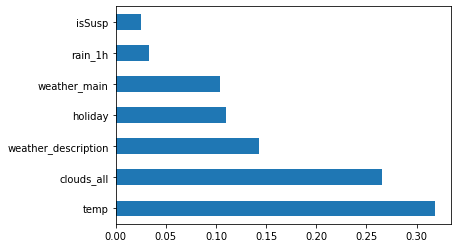

In [ ]:
(pd.Series(xmodel.feature_importances_, index=traffic.drop('traffic_volume', axis=1).columns).nlargest(7).plot(kind='barh'))

In [ ]:
validate.loc[validate.holiday != 'None', 'holiday'] = 1
validate.loc[validate.holiday != 1, 'holiday'] = 0
validate.holiday = validate.holiday.astype(np.uint8)
validate['isSusp'] = 0
validate.loc[validate.temp < 50, 'isSusp'] = 1
validate.loc[validate.snow_1h > 0.01, 'isSusp'] = 1
validate.loc[validate.rain_1h > 100, 'isSusp'] = 1 
validate.weather_main = validate.weather_main.map(weather_main_dict)
validate.weather_description = validate.weather_description.map(weather_description_dict).apply(lambda x: x / total_wd)
validate = reduce_memory(validate)

Memory usage of dataframe is 0.00 MB
Memory usage after optimization is: 0.00 MB
Decreased by 43.8%


In [ ]:
def custom_ts_multi_data_prep(dataset, target, start, end, window, horizon):
    X, y = [], []
    start += window
    if end is None:
        end = len(dataset) - horizon
    for i in range(start, end):
        indices = range(i-window, i)
        X.append(dataset[indices])
        indicesy = range(i+1, i+horizon+1)
        y.append(target[indicesy])
    return np.array(X), np.array(y)

In [ ]:
scaler = preprocessing.MinMaxScaler()
y_scaler = preprocessing.MinMaxScaler()
dataX = scaler.fit_transform(traffic)
dataY = y_scaler.fit_transform(traffic[['traffic_volume']])

In [ ]:
hist_window = 48
horizon = 10
train_split = 30000
X_train_uni, y_train_uni = custom_ts_multi_data_prep(dataX, dataY, 0, train_split, hist_window, horizon)
X_valid_uni, y_valid_uni = custom_ts_multi_data_prep(dataX, dataY, train_split, None, hist_window, horizon)

In [ ]:
batch_size = 256
buffer_size = 150
train_uni = tf.data.Dataset.from_tensor_slices((X_train_uni, y_train_uni))
train_uni = train_uni.cache().shuffle(buffer_size).batch(batch_size).repeat()
valid_uni = tf.data.Dataset.from_tensor_slices((X_valid_uni, y_valid_uni))
valid_uni = valid_uni.batch(batch_size).repeat()
model_path = r'/content/drive/My Drive/data/exchange/lstm_multi.h5'

In [ ]:
seq = [
       tf.keras.layers.LSTM(150, input_shape=X_train_uni.shape[-2:], return_sequences=True),
       tf.keras.layers.Dropout(0.2),
       tf.keras.layers.LSTM(100, return_sequences=False),
       tf.keras.layers.Dropout(0.2),
       tf.keras.layers.Dense(horizon)
]
model = tf.keras.models.Sequential(seq)
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 48, 150)           96000     
                                                                 
 dropout (Dropout)           (None, 48, 150)           0         
                                                                 
 lstm_1 (LSTM)               (None, 100)               100400    
                                                                 
 dropout_1 (Dropout)         (None, 100)               0         
                                                                 
 dense (Dense)               (None, 10)                1010      
                                                                 
Total params: 197,410
Trainable params: 197,410
Non-trainable params: 0
_________________________________________________________________


In [ ]:
eval_interval = 100
epochs = 150
history = model.fit(train_uni, epochs=epochs, steps_per_epoch=eval_interval, validation_data=valid_uni,
                    validation_steps=50, verbose=1, 
                    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, 
                                                                verbose=1, mode='min'),
                               tf.keras.callbacks.ModelCheckpoint(model_path, monitor='val_loss', 
                                                                  save_best_only=True, mode='min', verbose=0)])

Epoch 1/150
100/100 [==============================] - 14s 56ms/step - loss: 0.0779 - val_loss: 0.0496
Epoch 2/150
100/100 [==============================] - 4s 42ms/step - loss: 0.0571 - val_loss: 0.0500
Epoch 3/150
100/100 [==============================] - 4s 42ms/step - loss: 0.0528 - val_loss: 0.0609
Epoch 4/150
100/100 [==============================] - 4s 45ms/step - loss: 0.0483 - val_loss: 0.0419
Epoch 5/150
100/100 [==============================] - 4s 43ms/step - loss: 0.0504 - val_loss: 0.0402
Epoch 6/150
100/100 [==============================] - 4s 43ms/step - loss: 0.0469 - val_loss: 0.0397
Epoch 7/150
100/100 [==============================] - 4s 43ms/step - loss: 0.0467 - val_loss: 0.0360
Epoch 8/150
100/100 [==============================] - 4s 43ms/step - loss: 0.0472 - val_loss: 0.0359
Epoch 9/150
100/100 [==============================] - 4s 42ms/step - loss: 0.0457 - val_loss: 0.0473
Epoch 10/150
100/100 [==============================] - 4s 42ms/step - loss: 0.04

In [ ]:
trained_model = tf.keras.models.load_model(model_path)

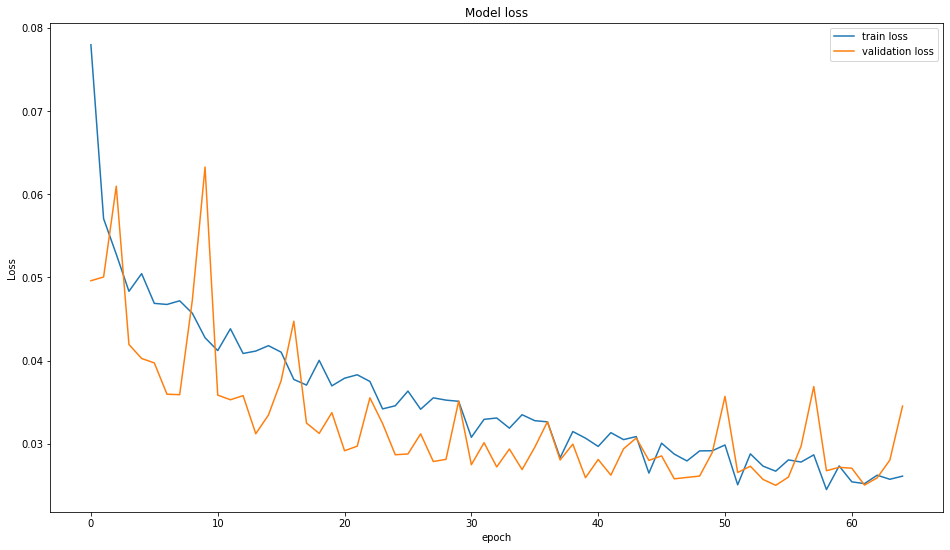

In [ ]:
plt.figure(figsize=(16,9))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train loss', 'validation loss'], loc='upper right')
plt.show()

In [ ]:
val_data = scaler.transform(traffic.tail(48))
val_rescaled = val_data.reshape(1, val_data.shape[0], val_data.shape[1])
preds = trained_model.predict(val_rescaled)

In [ ]:
preds_inverse = y_scaler.inverse_transform(preds)

In [ ]:
ts_eval_metrics(validate.traffic_volume, preds_inverse[0])

Evaluation metrics results: 
MSE: 489007.8125
MAE: 566.83056640625
RMSE: 699.2909545898438
MAPE: 32.18621611595154
R^2: 0.682528791513387



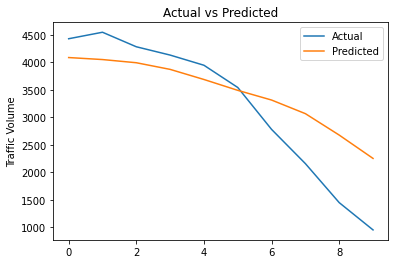

In [ ]:
plt.plot(validate.traffic_volume.tolist())
plt.plot(preds_inverse[0])
plt.title('Actual vs Predicted')
plt.ylabel('Traffic Volume')
plt.legend(['Actual', 'Predicted'])
plt.show()

In [ ]:
# Bidirectional LSTM multi horizon

In [ ]:
traffic = pd.read_csv('/content/drive/My Drive/data/exchange/traffic.csv')
traffic.set_index(pd.to_datetime(traffic['date_time']), drop=True, inplace=True)
traffic.drop_duplicates(subset=['date_time'], keep=False, inplace=True)
validate = traffic.drop('date_time', axis=1).tail(10)
traffic.drop(traffic.tail(10).index, inplace=True)
traffic.loc[traffic.holiday != 'None', 'holiday'] = 1
traffic.loc[traffic.holiday != 1, 'holiday'] = 0
traffic.holiday = traffic.holiday.astype(np.uint8)
traffic['isSusp'] = 0
traffic.loc[traffic.temp < 50, 'isSusp'] = 1
traffic.loc[traffic.snow_1h > 0.01, 'isSusp'] = 1
traffic.loc[traffic.rain_1h > 100, 'isSusp'] = 1 
weather_main_dict = traffic.groupby(by=['weather_main'])['traffic_volume'].median().to_dict()
weather_description_dict = traffic.weather_description.value_counts().to_dict()
total_wd = traffic.weather_description.shape[0]
traffic.weather_main = traffic.weather_main.map(weather_main_dict)
traffic.weather_description = traffic.weather_description.map(weather_description_dict).apply(lambda x: x / total_wd)
traffic.drop('date_time', axis=1, inplace=True)
traffic = reduce_memory(traffic)
validate.loc[validate.holiday != 'None', 'holiday'] = 1
validate.loc[validate.holiday != 1, 'holiday'] = 0
validate.holiday = validate.holiday.astype(np.uint8)
validate['isSusp'] = 0
validate.loc[validate.temp < 50, 'isSusp'] = 1
validate.loc[validate.snow_1h > 0.01, 'isSusp'] = 1
validate.loc[validate.rain_1h > 100, 'isSusp'] = 1 
validate.weather_main = validate.weather_main.map(weather_main_dict)
validate.weather_description = validate.weather_description.map(weather_description_dict).apply(lambda x: x / total_wd)
validate = reduce_memory(validate)
scaler = preprocessing.MinMaxScaler()
y_scaler = preprocessing.MinMaxScaler()
dataX = scaler.fit_transform(traffic)
dataY = y_scaler.fit_transform(traffic[['traffic_volume']])
hist_window = 48
horizon = 10
train_split = 30000
X_train_uni, y_train_uni = custom_ts_multi_data_prep(dataX, dataY, 0, train_split, hist_window, horizon)
X_valid_uni, y_valid_uni = custom_ts_multi_data_prep(dataX, dataY, train_split, None, hist_window, horizon)
batch_size = 256
buffer_size = 150
train_uni = tf.data.Dataset.from_tensor_slices((X_train_uni, y_train_uni))
train_uni = train_uni.cache().shuffle(buffer_size).batch(batch_size).repeat()
valid_uni = tf.data.Dataset.from_tensor_slices((X_valid_uni, y_valid_uni))
valid_uni = valid_uni.batch(batch_size).repeat()
#model_path = r'/content/drive/My Drive/data/exchange/lstm_bi_multi.h5'
#model_path = r'/content/drive/My Drive/data/exchange/lstm_autoenc_multi.h5'
#model_path = r'/content/drive/My Drive/data/exchange/lstm_gru_multi.h5'
model_path = r'/content/drive/My Drive/data/exchange/lstm_cnn_multi.h5'

Memory usage of dataframe is 2.44 MB
Memory usage after optimization is: 1.11 MB
Decreased by 54.8%
Memory usage of dataframe is 0.00 MB
Memory usage after optimization is: 0.00 MB
Decreased by 54.8%


In [ ]:
seq = [
       tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(150, return_sequences=True), 
                                     input_shape=X_train_uni.shape[-2:]),
       tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(50)),
       tf.keras.layers.Dense(20, activation='relu'),
       tf.keras.layers.Dropout(0.2),
       tf.keras.layers.Dense(horizon)
]
model = tf.keras.models.Sequential(seq)
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 48, 300)          192000    
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 100)              140400    
 nal)                                                            
                                                                 
 dense_1 (Dense)             (None, 20)                2020      
                                                                 
 dropout_2 (Dropout)         (None, 20)                0         
                                                                 
 dense_2 (Dense)             (None, 10)                210       
                                                                 
Total params: 334,630
Trainable params: 334,630
Non-tr

In [ ]:
eval_interval = 100
epochs = 150
history = model.fit(train_uni, epochs=epochs, steps_per_epoch=eval_interval, validation_data=valid_uni,
                    validation_steps=50, verbose=1, 
                    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, 
                                                                verbose=1, mode='min'),
                               tf.keras.callbacks.ModelCheckpoint(model_path, monitor='val_loss', 
                                                                  save_best_only=True, mode='min', verbose=0)])

Epoch 1/150
100/100 [==============================] - 16s 96ms/step - loss: 0.1373 - val_loss: 0.0711
Epoch 2/150
100/100 [==============================] - 8s 80ms/step - loss: 0.0830 - val_loss: 0.0585
Epoch 3/150
100/100 [==============================] - 8s 78ms/step - loss: 0.0692 - val_loss: 0.0717
Epoch 4/150
100/100 [==============================] - 8s 82ms/step - loss: 0.0579 - val_loss: 0.0424
Epoch 5/150
100/100 [==============================] - 8s 81ms/step - loss: 0.0558 - val_loss: 0.0376
Epoch 6/150
100/100 [==============================] - 8s 81ms/step - loss: 0.0504 - val_loss: 0.0367
Epoch 7/150
100/100 [==============================] - 8s 81ms/step - loss: 0.0486 - val_loss: 0.0343
Epoch 8/150
100/100 [==============================] - 8s 79ms/step - loss: 0.0478 - val_loss: 0.0354
Epoch 9/150
100/100 [==============================] - 8s 79ms/step - loss: 0.0459 - val_loss: 0.0374
Epoch 10/150
100/100 [==============================] - 8s 78ms/step - loss: 0.04

In [ ]:
trained_model = tf.keras.models.load_model(model_path)

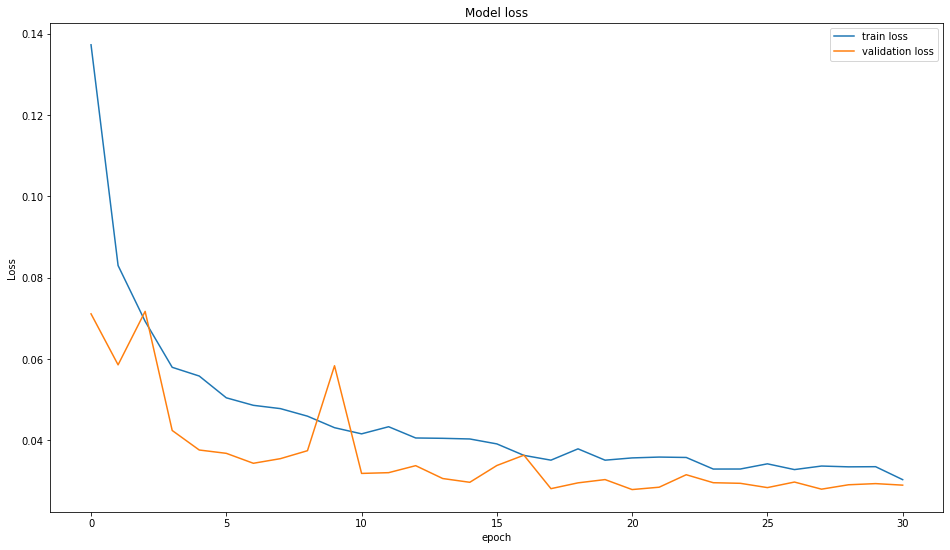

In [ ]:
plt.figure(figsize=(16,9))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train loss', 'validation loss'], loc='upper right')
plt.show()

In [ ]:
val_data = scaler.transform(traffic.tail(48))
val_rescaled = val_data.reshape(1, val_data.shape[0], val_data.shape[1])
preds = trained_model.predict(val_rescaled)

In [ ]:
preds_inverse = y_scaler.inverse_transform(preds)

In [ ]:
ts_eval_metrics(validate.traffic_volume, preds_inverse[0])

Evaluation metrics results: 
MSE: 775426.3125
MAE: 638.3452758789062
RMSE: 880.5829467773438
MAPE: 40.052881836891174
R^2: 0.4965815880093598



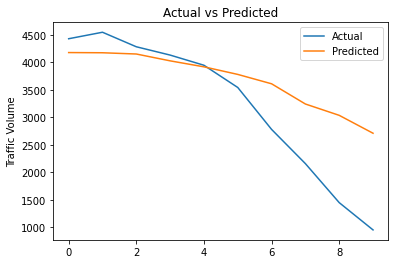

In [ ]:
plt.plot(validate.traffic_volume.tolist())
plt.plot(preds_inverse[0])
plt.title('Actual vs Predicted')
plt.ylabel('Traffic Volume')
plt.legend(['Actual', 'Predicted'])
plt.show()

In [ ]:
# AutoEncoder LSTM multi horizon

In [ ]:
seq = [
       tf.keras.layers.LSTM(40, input_shape=X_train_uni.shape[-2:], return_sequences=True),
       tf.keras.layers.LSTM(20, return_sequences=True),
       tf.keras.layers.LSTM(15),
       tf.keras.layers.RepeatVector(y_train_uni.shape[1]),
       tf.keras.layers.LSTM(40, return_sequences=True),
       tf.keras.layers.LSTM(25, return_sequences=True),
       tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(1))
]
model = tf.keras.models.Sequential(seq)
model.compile(optimizer='adam', loss='mse') # scheduler? lr?
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 48, 40)            8000      
                                                                 
 lstm_5 (LSTM)               (None, 48, 20)            4880      
                                                                 
 lstm_6 (LSTM)               (None, 15)                2160      
                                                                 
 repeat_vector (RepeatVector  (None, 10, 15)           0         
 )                                                               
                                                                 
 lstm_7 (LSTM)               (None, 10, 40)            8960      
                                                                 
 lstm_8 (LSTM)               (None, 10, 25)            6600      
                                                      

In [ ]:
eval_interval = 100
epochs = 150
history = model.fit(train_uni, epochs=epochs, steps_per_epoch=eval_interval, validation_data=valid_uni,
                    validation_steps=50, verbose=1, 
                    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, 
                                                                verbose=1, mode='min'),
                               tf.keras.callbacks.ModelCheckpoint(model_path, monitor='val_loss', 
                                                                  save_best_only=True, mode='min', verbose=0)])

Epoch 1/150
100/100 [==============================] - 17s 83ms/step - loss: 0.1029 - val_loss: 0.0817
Epoch 2/150
100/100 [==============================] - 6s 63ms/step - loss: 0.0772 - val_loss: 0.0765
Epoch 3/150
100/100 [==============================] - 6s 63ms/step - loss: 0.0651 - val_loss: 0.0715
Epoch 4/150
100/100 [==============================] - 6s 63ms/step - loss: 0.0535 - val_loss: 0.0525
Epoch 5/150
100/100 [==============================] - 6s 62ms/step - loss: 0.0543 - val_loss: 0.0459
Epoch 6/150
100/100 [==============================] - 6s 64ms/step - loss: 0.0512 - val_loss: 0.0448
Epoch 7/150
100/100 [==============================] - 6s 64ms/step - loss: 0.0506 - val_loss: 0.0437
Epoch 8/150
100/100 [==============================] - 6s 62ms/step - loss: 0.0513 - val_loss: 0.0449
Epoch 9/150
100/100 [==============================] - 6s 62ms/step - loss: 0.0498 - val_loss: 0.0527
Epoch 10/150
100/100 [==============================] - 6s 62ms/step - loss: 0.04

In [ ]:
trained_model = tf.keras.models.load_model(model_path)

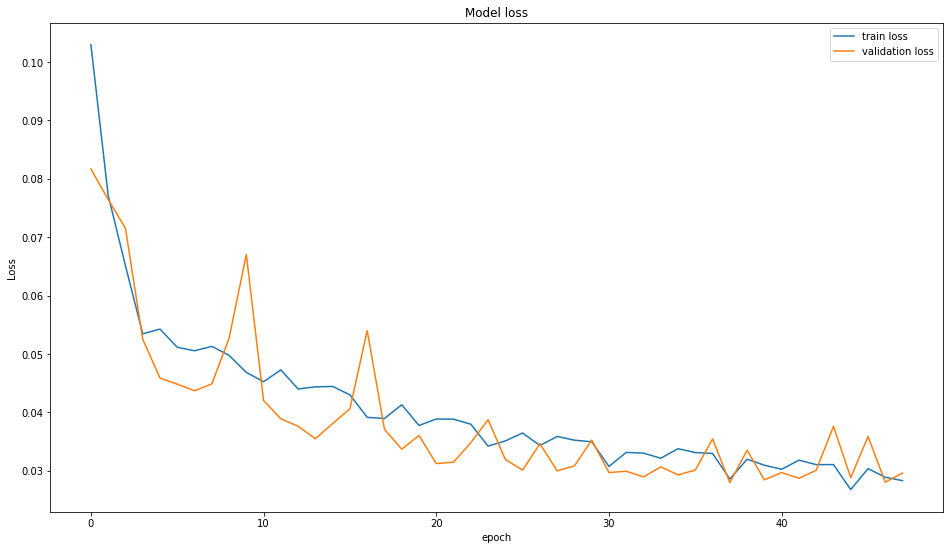

In [ ]:
plt.figure(figsize=(16,9))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train loss', 'validation loss'], loc='upper right')
plt.show()

In [ ]:
val_data = scaler.transform(traffic.tail(48))
val_rescaled = val_data.reshape(1, val_data.shape[0], val_data.shape[1])
preds = trained_model.predict(val_rescaled)

In [ ]:
preds_inverse = y_scaler.inverse_transform(preds.reshape(-1,1))

In [ ]:
ts_eval_metrics(validate.traffic_volume, preds_inverse)

Evaluation metrics results: 
MSE: 364426.9375
MAE: 463.6177673339844
RMSE: 603.6778564453125
MAPE: 62.23052144050598
R^2: 0.7634085297168638



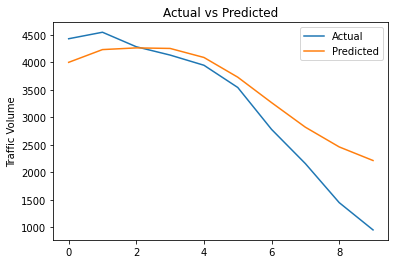

In [ ]:
plt.plot(validate.traffic_volume.tolist())
plt.plot(preds_inverse)
plt.title('Actual vs Predicted')
plt.ylabel('Traffic Volume')
plt.legend(['Actual', 'Predicted'])
plt.show()

In [ ]:
# GRU multi horizon

In [ ]:
seq = [
       tf.keras.layers.GRU(100, input_shape=X_train_uni.shape[-2:], return_sequences=True),
       tf.keras.layers.Dropout(0.2),
       tf.keras.layers.GRU(50, return_sequences=False),
       tf.keras.layers.Dropout(0.2),
       tf.keras.layers.Dense(horizon)
]
model = tf.keras.models.Sequential(seq)
model.compile(optimizer='adam', loss='mse') # scheduler? lr?
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 48, 100)           33300     
                                                                 
 dropout_3 (Dropout)         (None, 48, 100)           0         
                                                                 
 gru_1 (GRU)                 (None, 50)                22800     
                                                                 
 dropout_4 (Dropout)         (None, 50)                0         
                                                                 
 dense_4 (Dense)             (None, 10)                510       
                                                                 
Total params: 56,610
Trainable params: 56,610
Non-trainable params: 0
_________________________________________________________________


In [ ]:
eval_interval = 100
epochs = 150
history = model.fit(train_uni, epochs=epochs, steps_per_epoch=eval_interval, validation_data=valid_uni,
                    validation_steps=50, verbose=1, 
                    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, 
                                                                verbose=1, mode='min'),
                               tf.keras.callbacks.ModelCheckpoint(model_path, monitor='val_loss', 
                                                                  save_best_only=True, mode='min', verbose=0)])

Epoch 1/150
100/100 [==============================] - 7s 42ms/step - loss: 0.0890 - val_loss: 0.0557
Epoch 2/150
100/100 [==============================] - 3s 33ms/step - loss: 0.0626 - val_loss: 0.0558
Epoch 3/150
100/100 [==============================] - 3s 32ms/step - loss: 0.0551 - val_loss: 0.0663
Epoch 4/150
100/100 [==============================] - 3s 33ms/step - loss: 0.0505 - val_loss: 0.0390
Epoch 5/150
100/100 [==============================] - 3s 33ms/step - loss: 0.0514 - val_loss: 0.0379
Epoch 6/150
100/100 [==============================] - 3s 32ms/step - loss: 0.0476 - val_loss: 0.0353
Epoch 7/150
100/100 [==============================] - 3s 32ms/step - loss: 0.0468 - val_loss: 0.0347
Epoch 8/150
100/100 [==============================] - 3s 32ms/step - loss: 0.0469 - val_loss: 0.0358
Epoch 9/150
100/100 [==============================] - 3s 32ms/step - loss: 0.0455 - val_loss: 0.0396
Epoch 10/150
100/100 [==============================] - 3s 32ms/step - loss: 0.042

In [ ]:
trained_model = tf.keras.models.load_model(model_path)

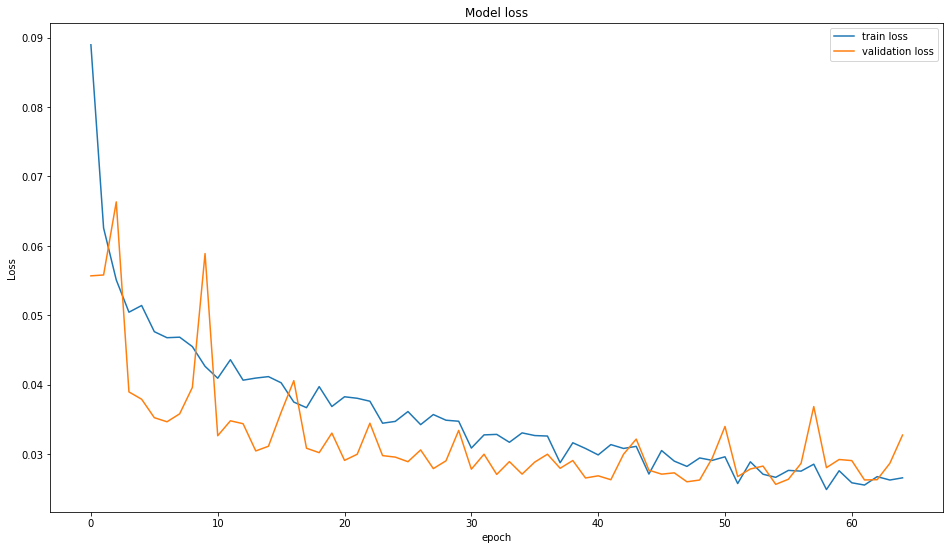

In [ ]:
plt.figure(figsize=(16,9))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train loss', 'validation loss'], loc='upper right')
plt.show()

Evaluation metrics results: 
MSE: 377307.375
MAE: 482.1123046875
RMSE: 614.2535400390625
MAPE: 28.172236680984497
R^2: 0.7550463654249203



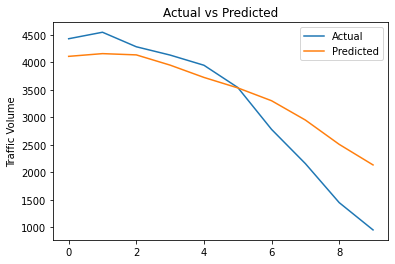

In [ ]:
val_data = scaler.transform(traffic.tail(48))
val_rescaled = val_data.reshape(1, val_data.shape[0], val_data.shape[1])
preds = trained_model.predict(val_rescaled)
preds_inverse = y_scaler.inverse_transform(preds)
ts_eval_metrics(validate.traffic_volume, preds_inverse[0])
plt.plot(validate.traffic_volume.tolist())
plt.plot(preds_inverse[0])
plt.title('Actual vs Predicted')
plt.ylabel('Traffic Volume')
plt.legend(['Actual', 'Predicted'])
plt.show()

In [ ]:
# CNN multi horizon

In [ ]:
seq = [
       tf.keras.layers.Conv1D(filters=64, kernel_size=3, activation='relu', 
                              input_shape=((X_train_uni.shape[1], X_train_uni.shape[2]))),
       tf.keras.layers.MaxPool1D(pool_size=2), # Batchnorm? global_avg_pool
       tf.keras.layers.Dropout(0.2),
       tf.keras.layers.Flatten(),
       #tf.keras.layers.GlobalAveragePooling1D(), # too small architecture to reduce the params
       tf.keras.layers.Dense(30, activation='relu'),
       tf.keras.layers.Dropout(0.2),
       tf.keras.layers.Dense(horizon),
]
model = tf.keras.models.Sequential(seq)
model.compile(optimizer='adam', loss='mse') # scheduler? lr?
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_2 (Conv1D)           (None, 46, 64)            1792      
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 23, 64)           0         
 1D)                                                             
                                                                 
 dropout_9 (Dropout)         (None, 23, 64)            0         
                                                                 
 flatten_1 (Flatten)         (None, 1472)              0         
                                                                 
 dense_9 (Dense)             (None, 30)                44190     
                                                                 
 dropout_10 (Dropout)        (None, 30)                0         
                                                      

In [ ]:
eval_interval = 100
epochs = 150
history = model.fit(train_uni, epochs=epochs, steps_per_epoch=eval_interval, validation_data=valid_uni,
                    validation_steps=50, verbose=1, 
                    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, 
                                                                verbose=1, mode='min'),
                               tf.keras.callbacks.ModelCheckpoint(model_path, monitor='val_loss', 
                                                                  save_best_only=True, mode='min', verbose=0)])

Epoch 1/150
100/100 [==============================] - 1s 10ms/step - loss: 0.1047 - val_loss: 0.0606
Epoch 2/150
100/100 [==============================] - 1s 9ms/step - loss: 0.0749 - val_loss: 0.0542
Epoch 3/150
100/100 [==============================] - 1s 8ms/step - loss: 0.0656 - val_loss: 0.0550
Epoch 4/150
100/100 [==============================] - 1s 8ms/step - loss: 0.0555 - val_loss: 0.0430
Epoch 5/150
100/100 [==============================] - 1s 8ms/step - loss: 0.0553 - val_loss: 0.0397
Epoch 6/150
100/100 [==============================] - 1s 9ms/step - loss: 0.0501 - val_loss: 0.0385
Epoch 7/150
100/100 [==============================] - 1s 9ms/step - loss: 0.0485 - val_loss: 0.0367
Epoch 8/150
100/100 [==============================] - 1s 9ms/step - loss: 0.0480 - val_loss: 0.0365
Epoch 9/150
100/100 [==============================] - 1s 8ms/step - loss: 0.0466 - val_loss: 0.0405
Epoch 10/150
100/100 [==============================] - 1s 8ms/step - loss: 0.0450 - val_l

In [ ]:
trained_model = tf.keras.models.load_model(model_path)

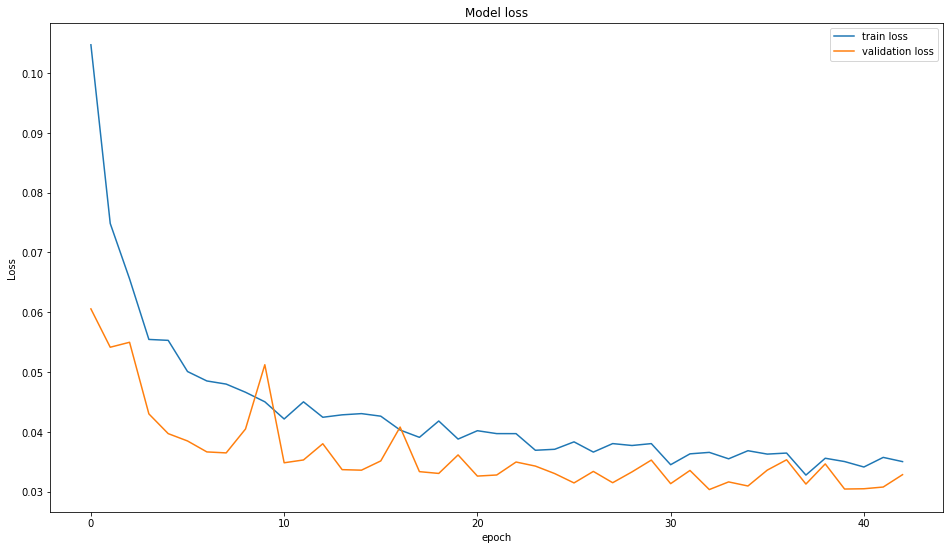

In [ ]:
plt.figure(figsize=(16,9))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train loss', 'validation loss'], loc='upper right')
plt.show()

Evaluation metrics results: 
MSE: 476812.59375
MAE: 524.9910888671875
RMSE: 690.5161743164062
MAPE: 32.037898898124695
R^2: 0.6904460817333591



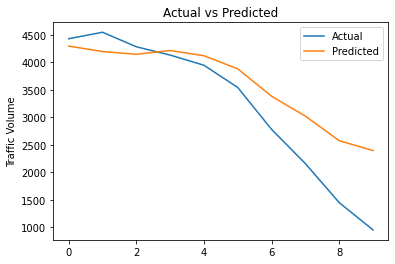

In [ ]:
val_data = scaler.transform(traffic.tail(48))
val_rescaled = val_data.reshape(1, val_data.shape[0], val_data.shape[1])
preds = trained_model.predict(val_rescaled)
preds_inverse = y_scaler.inverse_transform(preds)
ts_eval_metrics(validate.traffic_volume, preds_inverse[0])
plt.plot(validate.traffic_volume.tolist())
plt.plot(preds_inverse[0])
plt.title('Actual vs Predicted')
plt.ylabel('Traffic Volume')
plt.legend(['Actual', 'Predicted'])
plt.show()